In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import RandomOverSampler 

from functions.Pre_processing_Casos_Graves import *
from functions.Pre_processing_models import *

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

## Criação das funções para viabilizar a aplicação do modelo:

#### Função para instanciar o modelo:

In [2]:
from sklearn.neighbors import KNeighborsClassifier

def instantiate_KNN_model (X_train, y_train):
    k_range = range(1, 31)
    param_grid = {"n_neighbors": k_range}
    #scores = ['accuracy','f1','precision','recall','roc_auc']

    #Init classifier
    knn = KNeighborsClassifier()

    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 1)

    # Init Grid Search
    grid_cv = GridSearchCV(knn, param_grid, n_jobs = -1, cv=5, scoring = 'roc_auc')
    #grid_cv = GridSearchCV(knn, param_grid, n_jobs = -1, cv=cv, scoring = scores, refit='accuracy')

    # Fit 
    grid_cv.fit(X_train, y_train)

    #mean_test_score = grid_cv.cv_results_['mean_test_score']
    #std_test_score = grid_cv.cv_results_['std_test_score']
    best_score = grid_cv.best_score_
    best_params = grid_cv.best_params_

    print('#'*40)
    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score']}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score']}")
    print('')
    print(f'best_score: {grid_cv.best_score_}')
    print(f'best_params_: {grid_cv.best_params_}')
    print('#'*40)
    print('')

    return best_score, best_params

#### Criação de uma função para predição do classificador final:

In [3]:
from sklearn.neighbors import KNeighborsClassifier

def create_final_cl(X_over, y_over, X_test, y_test, n_neighbors):

    result_accuracy = []
    result_f1 = []
    result_precision = []
    result_recall = []
    result_roc_auc = []

    # parametrizando o modelo final
    final_cl = KNeighborsClassifier(n_neighbors=n_neighbors)

    #treinando o modelo final
    final_cl.fit(X_over, y_over)

    preds = final_cl.predict(X_test)

    accuracy_score(y_test, preds)

    print('"""Accuracy"""')
    print('accuracy_score:', accuracy_score(y_test, preds))
    print('#'*40)
    print('"""Métricas f1_score:"""')
    print('f1: ', f1_score(y_test, preds))
    print('macro: ', f1_score(y_test, preds, average='macro'))
    print('micro: ', f1_score(y_test, preds, average='micro'))
    print('weighted: ', f1_score(y_test, preds, average='weighted'))
    print('#'*40)
    print('"""Métricas precision_score:"""')
    print('Precision: ', precision_score(y_test, preds))
    print('macro: ', precision_score(y_test, preds, average='macro'))
    print('micro: ', precision_score(y_test, preds, average='micro'))
    print('weighted: ', precision_score(y_test, preds, average='weighted'))
    print('#'*40)
    print('"""Métricas recall_score:"""')
    print('Recall: ', recall_score(y_test, preds))
    print('macro: ', recall_score(y_test, preds, average='macro'))
    print('micro: ', recall_score(y_test, preds, average='micro'))
    print('weighted: ', recall_score(y_test, preds, average='weighted'))
    print('#'*40)
    print('"""ROC_AUC Score:"""')
    print('roc_auc_score: ', roc_auc_score(y_test, preds, multi_class='ovr'))

    result_accuracy.append(accuracy_score(y_test, preds))

    result_f1.append(f1_score(y_test, preds))
    result_f1.append(f1_score(y_test, preds, average='macro'))
    result_f1.append(f1_score(y_test, preds, average='micro'))
    result_f1.append(f1_score(y_test, preds, average='micro'))

    result_precision.append(precision_score(y_test, preds))
    result_precision.append(precision_score(y_test, preds, average='macro'))
    result_precision.append(precision_score(y_test, preds, average='micro'))
    result_precision.append(precision_score(y_test, preds, average='weighted'))

    result_recall.append(precision_score(y_test, preds))
    result_recall.append(precision_score(y_test, preds, average='macro'))
    result_recall.append(precision_score(y_test, preds, average='micro'))
    result_recall.append(precision_score(y_test, preds, average='weighted'))

    result_roc_auc.append(roc_auc_score(y_test, preds, multi_class='ovr'))

    return preds, final_cl, result_accuracy, result_f1, result_precision, result_recall, result_roc_auc

#### Criação de funções para plotagem de métricas:

In [4]:
def plot_conf_matrix (X_test, y_test, preds, final_cl):

    confusion_matrix(y_test, preds)
    matrix = plot_confusion_matrix(final_cl, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()
    print(classification_report(y_test, preds))


def plot_roc_curve(y_test, preds):
    
    print('roc_auc_score: ', roc_auc_score(y_test, preds, multi_class='ovr'))

    fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
    auc = metrics.roc_auc_score(y_test, preds)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

def plot_permutation_importance(final_cl, X_test, y_test):
    perm_importance = permutation_importance(final_cl, X_test, y_test)

    sorted_idx = perm_importance.importances_mean.argsort()
    plt.figure(figsize=(10,10))
    plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx], height=0.8)
    plt.xlabel("Permutation Importance")
    plt.show()

#### Criação de uma função para aplicar o modelo para o período de tempo escolhido:

In [11]:
def apply_periodos (d, df):

    results_accuracy = []
    results_f1 = []
    results_precision = []
    results_recall = []
    results_roc_auc = []

    if d == 90:
        for i in range (0,758,30):
    
            #treino!
            data_inicio = df['data_notificacao'][0] + pd.Timedelta(days = i)
            data_fim_treino = data_inicio + pd.Timedelta(days = int(d/2))
            data_fim = data_inicio + pd.Timedelta(days = d)
        
            treino = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] <= data_fim_treino )]
            X_train = treino.drop(labels=['death', 'data_notificacao'], axis=1)
            y_train = treino['death']

            #teste!
            teste = df[(df['data_notificacao'] > data_fim_treino) & (df['data_notificacao'] <= data_fim )]
            X_test = teste.drop(labels=['death', 'data_notificacao'], axis=1)
            y_test = teste['death']

            oversample = RandomOverSampler(sampling_strategy='minority')
            X_over, y_over = oversample.fit_resample(X_train, y_train)

            print('Início do período: ', data_inicio)
            print('Final do período: ', data_fim)

            ####################################################
            #              APLICANDO O MODELO                  #
            ####################################################

            list_random_states = [42]

            best_scores = []
            best_params = []

            for random_state in list_random_states:

                best_score, best_param = instantiate_KNN_model(X_over, y_over)

                best_scores.append(best_score)
                best_params.append(best_param)

            idx = best_scores.index(max(best_scores))
            best_param = best_params[idx]
        
            preds, final_cl, result_accuracy, result_f1, result_precision, result_recall, result_roc_auc = create_final_cl(X_over, y_over, X_test, y_test, best_param['n_neighbors'])

            results_accuracy.append(result_accuracy)
            results_f1.append(result_f1)
            results_precision.append(result_precision)
            results_recall.append(result_recall)
            results_roc_auc.append(result_roc_auc)

            plot_conf_matrix (X_test, y_test, preds, final_cl)

            plot_roc_curve(y_test, preds)

            plot_permutation_importance(final_cl, X_test, y_test)

        return results_accuracy, results_f1, results_precision, results_recall, results_roc_auc

    if d == 120:
        for i in range (0,728,30):
    
            #treino!
            data_inicio = df['data_notificacao'][0] + pd.Timedelta(days = i)
            data_fim_treino = data_inicio + pd.Timedelta(days = int(d/2))
            data_fim = data_inicio + pd.Timedelta(days = d)
        
            treino = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] <= data_fim_treino )]
            X_train = treino.drop(labels=['death', 'data_notificacao'], axis=1)
            y_train = treino['death']

            #teste!
            teste = df[(df['data_notificacao'] > data_fim_treino) & (df['data_notificacao'] <= data_fim )]
            X_test = teste.drop(labels=['death', 'data_notificacao'], axis=1)
            y_test = teste['death']

            oversample = RandomOverSampler(sampling_strategy='minority')
            X_over, y_over = oversample.fit_resample(X_train, y_train)

            print('Início do período: ', data_inicio)
            print('Final do período: ', data_fim)

            ####################################################
            #              APLICANDO O MODELO                  #
            ####################################################

            list_random_states = [42]

            best_scores = []
            best_params = []

            for random_state in list_random_states:

                best_score, best_param = instantiate_KNN_model(X_over, y_over)

                best_scores.append(best_score)
                best_params.append(best_param)

            idx = best_scores.index(max(best_scores))
            best_param = best_params[idx]
        
            preds, final_cl, result_accuracy, result_f1, result_precision, result_recall, result_roc_auc = create_final_cl(X_over, y_over, X_test, y_test, best_param['n_neighbors'])

            results_accuracy.append(result_accuracy)
            results_f1.append(result_f1)
            results_precision.append(result_precision)
            results_recall.append(result_recall)
            results_roc_auc.append(result_roc_auc)

            plot_conf_matrix (X_test, y_test, preds, final_cl)

            plot_roc_curve(y_test, preds)

            plot_permutation_importance(final_cl, X_test, y_test)

        return results_accuracy, results_f1, results_precision, results_recall, results_roc_auc


## Lendo o dataset:

In [6]:
df = pd.read_csv('..\Data\Casos Graves\df_casos_graves')

### Utilizando a class de pré-processamento para preparar o dataset:

In [7]:
list_features = ["SYMPTOM_COUGH",'SYMPTOM_COLD','SYMPTOM_AIR_INSUFFICIENCY','SYMPTOM_FEVER','SYMPTOM_LOW_OXYGEN_SATURATION','SYMPTOM_BREATHING_CONDITION','SYMPTOM_TORACIC_APERTURE','SYMPTOM_THROAT_CONDITION',
                'SYMPTOM_HEADACHE','SYMPTOM_BODY_PAIN','SYMPTOM_DIARRHEA','SYMPTOM_RUNNY_NOSE','SYMPTOM_NOSE_CONGESTION','SYMPTOM_WEAKNESS','SYMPTOM_ANOSMIA_OR_HYPOSMIA','SYMPTOM_NAUSEA','SYMPTOM_LACK_OF_APPETITE',
                'SYMPTOM_ABDOMINAL_PAIN','SYMPTOM_CONSCIOUSNESS_DEGRADATION','DISEASE_HEART_OR_VASCULAR','DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY','DISEASE_KIDNEY','DISEASE_IMMUNOSUPPRESSION',
                'DISEASE_TABAGIST','DISEASE_ETILISM','DISEASE_LIVER','DISEASE_NEUROLOGIC','death', 'idade', 'sexo_Feminino','sexo_Masculino', 'data_notificacao']
features = np.array(list_features)

In [8]:
Pre_processing_models_df = Pre_processing_models(df)
Pre_processing_models_df.run_graves()

df = Pre_processing_models_df.df
df = df[list_features]
df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])
df = df.sort_values(by='data_notificacao', ascending=True)
df = df.reset_index()
df = df.drop("index", axis=1)
df

C:\Users\gabri\AppData\Local\Temp\ipykernel_17288\3432879523.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.356522,0,1,2020-02-26
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.278261,0,1,2020-02-26
2,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.217391,1,0,2020-02-27
3,1,0,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0.278261,0,1,2020-02-27
4,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0.260870,1,0,2020-02-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36430,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,1,0,2022-06-12
36431,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.556522,0,1,2022-06-12
36432,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.573913,1,0,2022-06-12
36433,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0,1,2022-06-13


### Aplicação do modelo considerando períodos de 90 dias, deslocando cada período em 30 dias:

Início do período:  2020-02-26 00:00:00
Final do período:  2020-05-26 00:00:00
########################################

best_score: 0.933864062643322
best_params_: {'n_neighbors': 6}
########################################

accuracy_score: 0.7692823608316566
########################################
"""Métricas f1_score:"""
f1:  0.5612244897959183
Macro:  0.7023592876641103
Micro:  0.7692823608316566
weighted:  0.7789690102717494
########################################
"""Métricas precision_score:"""
Precision:  0.49642722828130875
Macro:  0.690554953412167
Micro:  0.7692823608316566
weighted:  0.7959298956472941


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


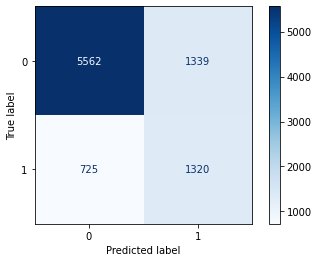

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      6901
           1       0.50      0.65      0.56      2045

    accuracy                           0.77      8946
   macro avg       0.69      0.73      0.70      8946
weighted avg       0.80      0.77      0.78      8946

roc_auc_score:  0.7257234609349341


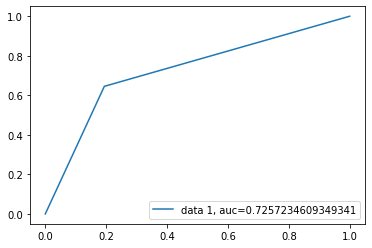

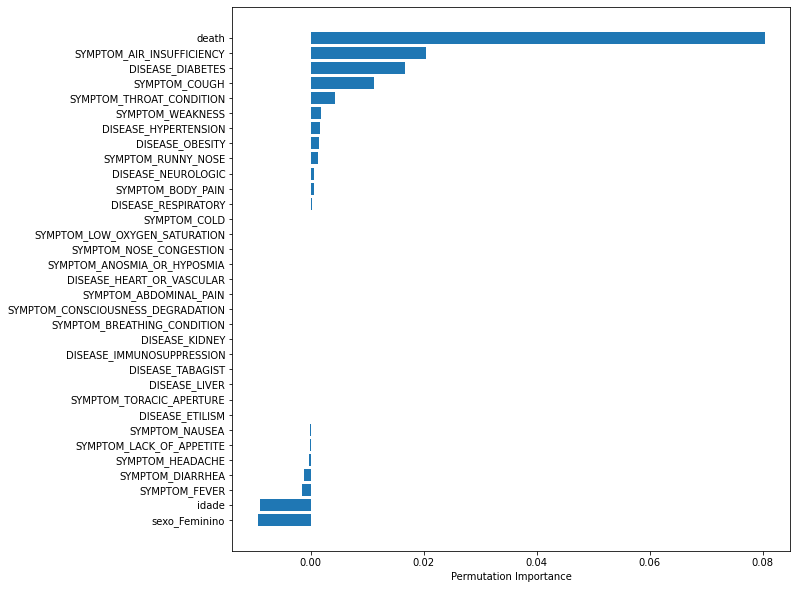

Início do período:  2020-03-27 00:00:00
Final do período:  2020-06-25 00:00:00
########################################

best_score: 0.908766404107914
best_params_: {'n_neighbors': 12}
########################################

accuracy_score: 0.6791402801765496
########################################
"""Métricas f1_score:"""
f1:  0.5483522420313345
Macro:  0.6497713591109053
Micro:  0.6791402801765496
weighted:  0.6973182604782805
########################################
"""Métricas precision_score:"""
Precision:  0.43787748058671266
Macro:  0.6551641118799446
Micro:  0.6791402801765496
weighted:  0.75703155387752


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


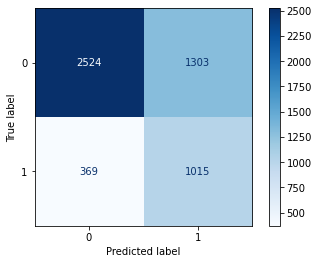

              precision    recall  f1-score   support

           0       0.87      0.66      0.75      3827
           1       0.44      0.73      0.55      1384

    accuracy                           0.68      5211
   macro avg       0.66      0.70      0.65      5211
weighted avg       0.76      0.68      0.70      5211

roc_auc_score:  0.6964529672799444


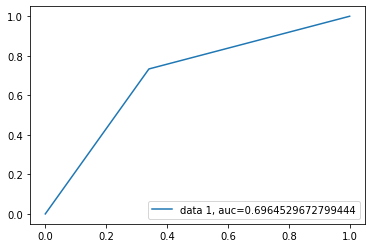

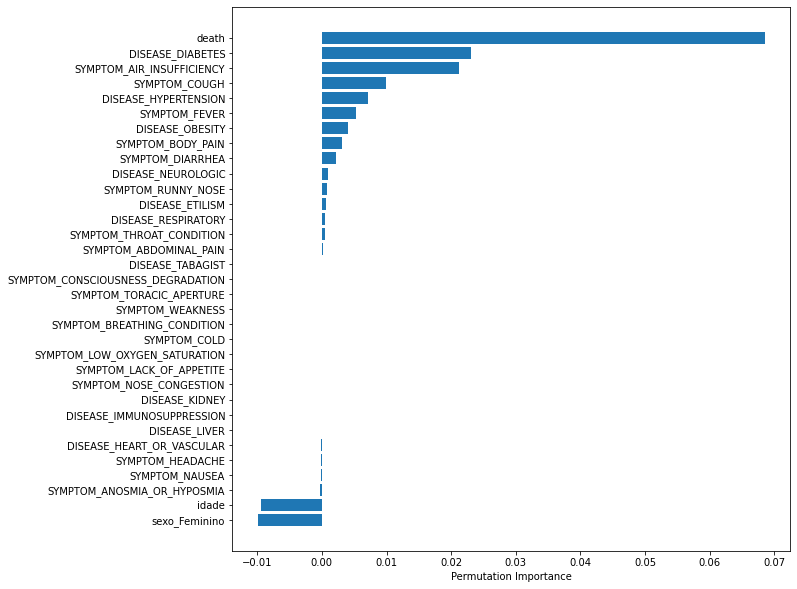

Início do período:  2020-04-26 00:00:00
Final do período:  2020-07-25 00:00:00
########################################

best_score: 0.8353350895393465
best_params_: {'n_neighbors': 6}
########################################

accuracy_score: 0.6881925869316011
########################################
"""Métricas f1_score:"""
f1:  0.45454545454545453
Macro:  0.6181234495841238
Micro:  0.6881925869316011
weighted:  0.7110697539870665
########################################
"""Métricas precision_score:"""
Precision:  0.3651987110633727
Macro:  0.6158733768839996
Micro:  0.6881925869316011
weighted:  0.7583086952161631


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


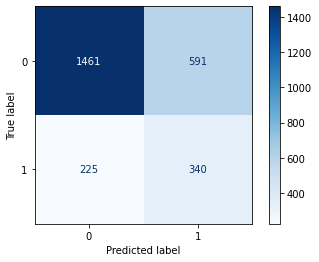

              precision    recall  f1-score   support

           0       0.87      0.71      0.78      2052
           1       0.37      0.60      0.45       565

    accuracy                           0.69      2617
   macro avg       0.62      0.66      0.62      2617
weighted avg       0.76      0.69      0.71      2617

roc_auc_score:  0.656879107798996


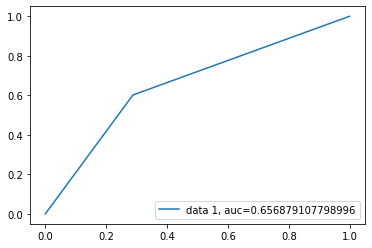

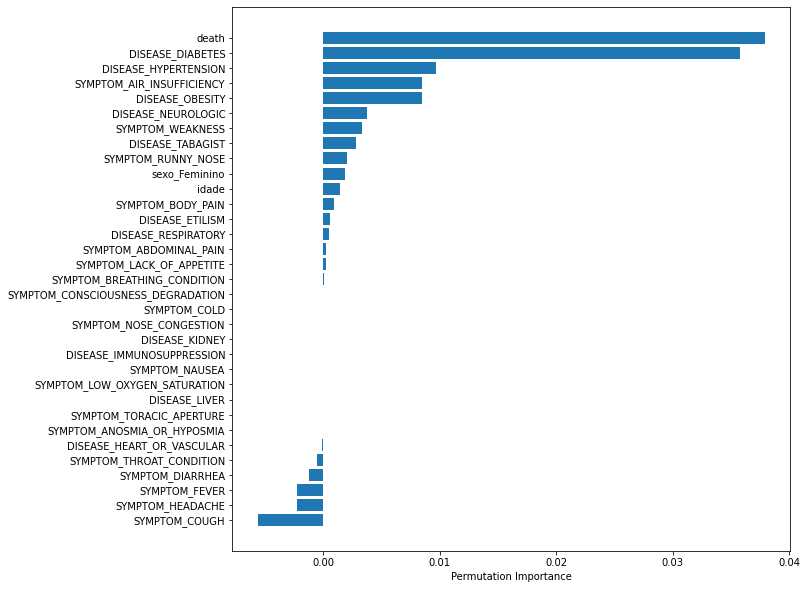

Início do período:  2020-05-26 00:00:00
Final do período:  2020-08-24 00:00:00
########################################

best_score: 0.8326839959412313
best_params_: {'n_neighbors': 2}
########################################

accuracy_score: 0.7462277091906722
########################################
"""Métricas f1_score:"""
f1:  0.34007134363852554
Macro:  0.591490526050794
Micro:  0.7462277091906722
weighted:  0.7470324345116075
########################################
"""Métricas precision_score:"""
Precision:  0.33726415094339623
Macro:  0.5909236239685784
Micro:  0.7462277091906722
weighted:  0.7478515009704402


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


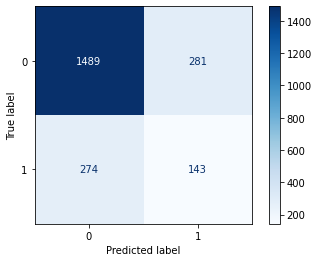

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1770
           1       0.34      0.34      0.34       417

    accuracy                           0.75      2187
   macro avg       0.59      0.59      0.59      2187
weighted avg       0.75      0.75      0.75      2187

roc_auc_score:  0.5920842986627648


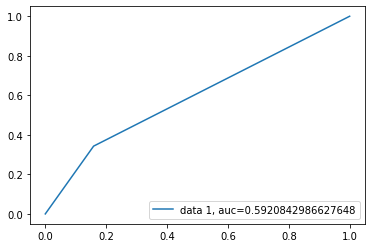

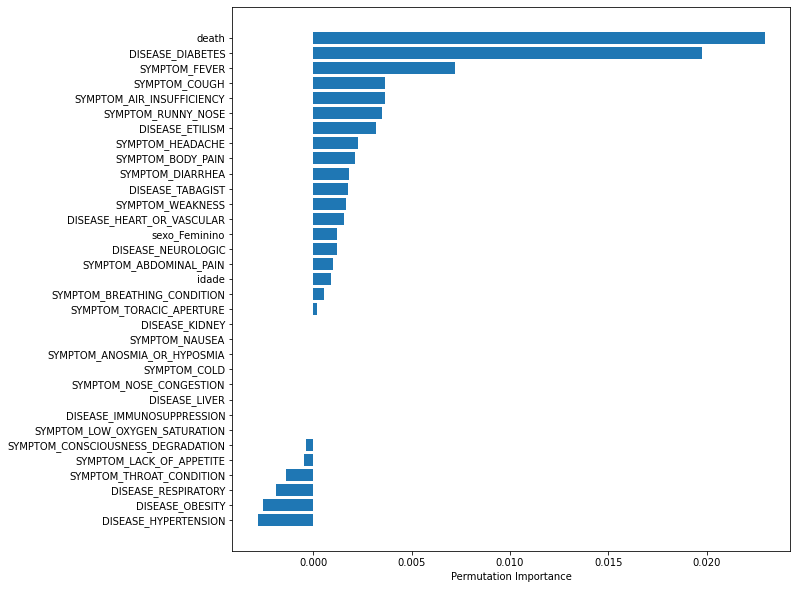

Início do período:  2020-06-25 00:00:00
Final do período:  2020-09-23 00:00:00


KeyboardInterrupt: 

In [12]:
results_accuracy_90_knn, results_f1_90_knn, results_precision_90_knn, results_recall_90_knn, results_roc_auc_90_knn = apply_periodos(90, df)

### Lista com as métricas de cada período:

In [ ]:
list_periodos_90 = [['26/02/2020 até 26/05/2020'], ['27/03/2020 até 25/06/2020'], ['26/04/2020 até 25/07/2020'], ['26/05/2020 até 24/08/2020'], 
['25/06/2020 até 23/09/2020'], ['25/07/2020 até 23/10/2020'], ['24/08/2020 até 22/11/2020'], ['23/09/2020 até 22/12/2020'], ['23/10/2020 até 21/01/2021'], 
['22/11/2020 até 20/02/2021'], ['22/12/2020 até 22/03/2022'], ['21/01/2021 até 21/04/2021'], ['20/02/2021 até 21/05/2021'], ['22/03/2021 até 20/06/2021'], 
['21/04/2021 até 20/07/2021'], ['21/05/2021 até 19/08/2021'], ['20/06/2021 até 18/09/2021'], ['20/07/2021 até 18/10/2021'], ['19/08/2021 até 17/11/2021'], 
['18/09/2021 até 17/12/2021'], ['18/10/2021 até 16/01/2022'], ['17/11/2021 até 15/02/2022'], ['17/12/2021 até 17/03/2022'], ['16/01/2022 até 16/04/2022'], 
['15/02/2022 até 16/05/2022'], ['17/03/2022 até 15/06/2022']]

In [ ]:
metricas_accuracy_90_knn = pd.DataFrame(results_accuracy_90_knn)
metricas_accuracy_90_knn.columns = ['accuracy score']
#metricas_accuracy_90_knn
metricas_f1_90_knn = pd.DataFrame(results_f1_90_knn)
metricas_f1_90_knn.columns = ['f1 score', 'f1 score macro', 'f1 score micro', 'f1 score weighted']
#metricas_f1_90_knn
metricas_precision_90_knn = pd.DataFrame(results_precision_90_knn)
metricas_precision_90_knn.columns = ['precision score', 'precision score macro', 'precision score micro', 'precision score weighted']
#metricas_precision_90_knn
metricas_recall_90_knn = pd.DataFrame(results_recall_90_knn)
metricas_recall_90_knn.columns = ['recall score', 'recall score macro', 'recall score micro', 'recall score weighted']
#metricas_recall_90_knn
metricas_roc_auc_90_knn = pd.DataFrame(results_roc_auc_90_knn)
metricas_roc_auc_90_knn.columns = ['roc_auc score']
#metricas_roc_auc_90_knn
metricas_90_knn = pd.concat([metricas_accuracy_90_knn, metricas_f1_90_knn, metricas_precision_90_knn, metricas_recall_90_knn, metricas_roc_auc_90_knn], axis=1)
metricas_90_knn

In [ ]:
coluna_periodos90 = pd.DataFrame(list_periodos_90)
coluna_periodos90.columns = ['Períodos']
#coluna_periodos90
metricas_90_knn_final = pd.concat([coluna_periodos90, metricas_90_knn], axis=1)
metricas_90_knn_final

In [ ]:
metricas_90_knn_final.sort_values(by=['roc_auc score'], ascending=False)

In [ ]:
metricas_90_knn_final.sort_values(by=['f1 score macro', 'roc_auc score'], ascending=False)

### Aplicação do modelo considerando períodos de 120 dias, deslocando cada período em 30 dias:

In [ ]:
results_accuracy_120_knn, results_f1_120_knn, results_precision_120_knn, results_recall_120_knn, results_roc_auc_120_knn = apply_periodos(120, df)

### Lista com as métricas de cada período:

In [ ]:
list_periodos_120 = [['26/02/2020 até 25/06/2020'], ['27/03/2020 até 25/07/2020'], ['26/04/2020 até 24/08/2020'], ['26/05/2020 até 23/09/2020'], 
['25/06/2020 até 23/10/2020'], ['25/07/2020 até 22/11/2020'], ['24/08/2020 até 22/12/2020'], ['23/09/2020 até 21/01/2021'], ['23/10/2020 até 20/02/2021'], 
['22/11/2020 até 22/03/2021'], ['22/12/2020 até 21/04/2021'], ['21/01/2021 até 21/05/2021'], ['20/02/2021 até 20/06/2021'], ['22/03/2021 até 20/07/2021'], 
['21/04/2021 até 19/08/2021'], ['21/05/2021 até 18/09/2021'], ['20/06/2021 até 18/10/2021'], ['20/07/2021 até 17/11/2021'], ['19/08/2021 até 17/12/2021'], 
['18/09/2021 até 16/01/2022'], ['18/10/2021 até 15/02/2022'], ['17/11/2021 até 17/03/2022'], ['17/12/2021 até 16/04/2022'], ['16/01/2022 até 16/05/2022'], 
['15/02/2022 até 15/06/2022']]

In [ ]:
metricas_accuracy_120_knn = pd.DataFrame(results_accuracy_120_knn)
metricas_accuracy_120_knn.columns = ['accuracy score']
#metricas_accuracy_120_knn
metricas_f1_120_knn = pd.DataFrame(results_f1_120_knn)
metricas_f1_120_knn.columns = ['f1 score', 'f1 score macro', 'f1 score micro', 'f1 score weighted']
#metricas_f1_120_knn
metricas_precision_120_knn = pd.DataFrame(results_precision_120_knn)
metricas_precision_120_knn.columns = ['precision score', 'precision score macro', 'precision score micro', 'precision score weighted']
#metricas_precision_120_knn
metricas_recall_120_knn = pd.DataFrame(results_recall_120_knn)
metricas_recall_120_knn.columns = ['recall score', 'recall score macro', 'recall score micro', 'recall score weighted']
#metricas_recall_120_knn
metricas_roc_auc_120_knn = pd.DataFrame(results_roc_auc_120_knn)
metricas_roc_auc_120_knn.columns = ['roc_auc score']
#metricas_roc_auc_120_knn
metricas_120_knn = pd.concat([metricas_accuracy_120_knn, metricas_f1_120_knn, metricas_precision_120_knn, metricas_recall_120_knn, metricas_roc_auc_120_knn], axis=1)
metricas_120_knn

In [ ]:
coluna_periodos120 = pd.DataFrame(list_periodos_120)
coluna_periodos120.columns = ['Períodos']
#coluna_periodos120.columns
metricas_120_knn_final = pd.concat([coluna_periodos120, metricas_120_knn], axis=1)
metricas_120_knn_final